# Session 2
In this session, we will use the prepared dataset of EGFR activity data from Session to train ML models that predict the pIC50 value of a given molecule. 

**Content:**
1. Featuration
2. Training a random forest (RF)
    1. Data splitting
    2. Training
    3. Model performance evaluation
    4. Interpreting the forest
4. Model comparision
    1. K-fold cross validation
    2. Comparing the RF with Ridge regression
    2. Model section with a Grid Search

In [77]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import statistics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from IPython.display import SVG
import seaborn as sns

First, we reload the prepared data from Session 1 into a DataFrame:

In [12]:
egfr_activities_df = pd.read_csv(
    "https://github.com/volkamerlab/cic_summerschool_2025/raw/refs/heads/main/data/EGFR-activities-prepared.csv",
    index_col=0,
)
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O


## Featuration
To use molecules in machine learning models, we need to encode them numerically. We do this by generating fingerprint bit vectors for each molecule. Each molecule is then represented as a vector of fixed length ($1024$ in our example).

In [13]:
fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=1024)

egfr_activities_df["morgan_fp"] = egfr_activities_df["canonical_smiles"].apply(
    lambda smiles: fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles))
)
egfr_activities_df.head()

,pIC50,standard_units,molecule_dictionary.chembl_id,canonical_smiles,morgan_fp
0,6.339419,nM,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5.484537,nM,CHEMBL1016,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5.136677,nM,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6.494850,nM,CHEMBL102726,c1ccc(CNc2ncnc3ccccc23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5.387216,nM,CHEMBL103552,O=C(O)c1cc(N(Cc2ccccc2O)Cc2cc(O)ccc2O)ccc1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Training a random forest (RF)
We aim to train a function that takes a bit vector as input and predicts the pIC50 value.

### Data splitting
Our goal is to be learn a (machine learning) model that generalizes well.

Therefore, we split our dataset into 2 subsets:
* A larger subset on which we will train our model called the *training set*.
* A smaller subset on which we will *test* the model. It is important that we evaluate our model on a subset of the data it has **never seen before** to ensure that we are not overfitting the data and that our model can generalize well to secret data.

Here, we will randomly split the data. However, note that usually in a real world scenaria, one should avoid random splitting in this area to avoid data leacage, e.g., since molecules with similar scaffold have been already seen during training. (TODO rephrase)

We use the `train_test_split` function of the **sklearn** library to split 80% of the data for training and 20% for testing. **sklearn** is a machine learning library that provides several convenient functions for machine learning.

In [ ]:
df_train, df_test = train_test_split(egfr_activities_df, test_size=0.2, random_state=42)
print(f"{len(df_train)} traing samples, {len(df_test)} test samples")

We convert our fingerprints (X) and pIC50 (y) values into **NumPy** arrays. **NumPy** allows to create vectors (1D), matrices (2D), tensors (>= 3D) in the form of arrays. Further it offers a large collection of efficient numerical operations on arrays, which is crucial for machine learning.

In [24]:
X_train, y_train = np.stack(df_train["morgan_fp"]), np.array(df_train["pIC50"])
X_test, y_test = np.stack(df_test["morgan_fp"]), np.array(df_test["pIC50"])

In [25]:
print(f"Dimentions of training input: {X_train.shape}")
print(f"Dimentions of training output: {y_train.shape}")
print(f"Dimentions of training input: {X_test.shape}")
print(f"Dimentions of training output: {y_test.shape}")

Dimentions of training input: (5358, 1024)
Dimentions of training output: (5358,)
Dimentions of training input: (1340, 1024)
Dimentions of training output: (1340,)


### Training 
With **sklearn**, we first initialize the model, fit it to the training data using the `fit`-function, and then predict on new inputs using the `predict`-function of the model.

Let's first initialize the RF with it's default parameters:

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.get_params()

RandomForestRegressor(random_state=42)

Next, we fit (train) the RF to our training data:

In [43]:
# fit the RF
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

The trained RF is now written to `rf_model`. We can use it's member functionc `predict` to predict the pIC50 values against EGFR for given molecules by their fingerprint.

In [54]:
smiles_caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
caffeine_fp = fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles_caffeine))

caffeine_activity = rf_model.predict([caffeine_fp])

print(f"Predicted pIC50 of caffein against EGFR: {caffeine_activity[0]:.2f}nM")

Predicted pIC50 of caffein against EGFR: 4.90nM


### Model performance evaluation

First we make predictions on the test set (`X_test`) that we will later compare to the respective true labels (`y_test`) to evaluate of our model.

In [ ]:
y_pred = rf_model.predict(X_test)

Test (MSE): 0.6564187034112835
Test (R^2): 0.6710319339224109


We compute the mean squared error (MSE) as well as the $R^2$ using the respective functions from the `sklearn.metrics` module.

In [55]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print(f"Test (MSE): {mse}")
print(f"Test (R^2): {r_square}")

Test (MSE): 0.6564187034112835
Test (R^2): 0.6710319339224109


Let's also visualize these results:

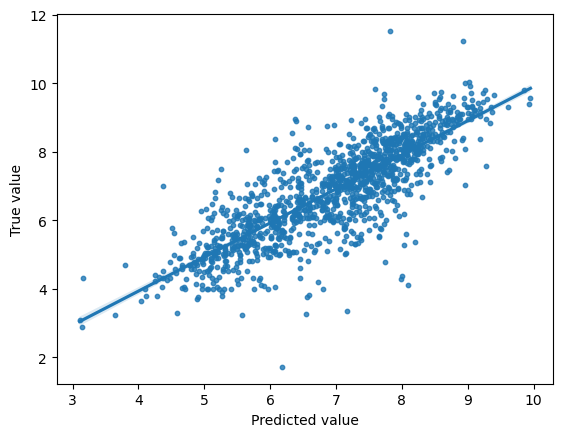

In [56]:
sns.regplot(x=y_pred, y=y_test, scatter_kws={"s": 10})
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.show()

### Interpreting the forest
Apart from evaluating model performance, we might also be interested in understanding what the model learned. One way to do this is by looking at **feature importance** — intuitively, this tells us which input features (fingerprint bits) had the greatest influence on the model’s predictions.

Top 3 bits: [428 128 621]


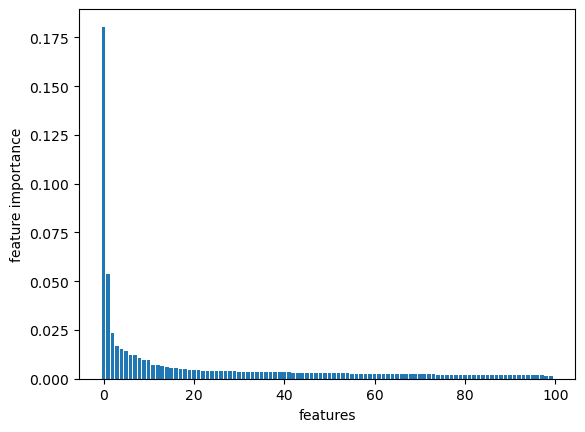

In [22]:
plt.bar(range(100), sorted(rf_model.feature_importances_, reverse=True)[:100])
plt.ylabel("feature importance")
plt.xlabel("features")
top3bits = np.argsort(rf_model.feature_importances_)[:-4:-1]
print(f"Top 3 bits: {top3bits}")

Let's look for an example substructure for the most import bit:

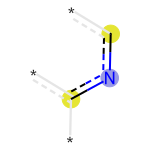

In [ ]:
top_bit = top3bits[0]
top_bit_active = df_train[
    df_train["morgan_fp"].apply(lambda fp: fp[top_bit] == 1)
].reset_index(drop=True)
example_mol = Chem.MolFromSmiles(top_bit_active["canonical_smiles"][0])
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetFingerprint(example_mol, additionalOutput=ao)
bi = ao.GetBitInfoMap()
Draw.DrawMorganBit(example_mol, top_bit, bi)

SVG(Draw.DrawMorganBit(example_mol, top_bit, bi))

##  Model comparison

In [58]:
X, y = np.stack(egfr_activities_df["morgan_fp"]), np.array(egfr_activities_df["pIC50"])

### K-fold cross validation
To have a better estimate on how a model generalized, i.e., performs on secret data, one often performs a cross validation instead of a simple train/test split. A common splitting technique is k-fold splt. In k-fold splits, the data is splitted into k subsets, in such a way that each data point is part of the test set exactly once.

For example, if we choose to do a 5-fold split, the summary of the process would be:

**Fold 1**: Train on Folds 2, 3, 4, 5 | Test on Fold 1

**Fold 2**: Train on Folds 1, 3, 4, 5 | Test on Fold 2

**Fold 3**: Train on Folds 1, 2, 4, 5 | Test on Fold 3

**Fold 4**: Train on Folds 1, 2, 3, 5 | Test on Fold 4

**Fold 5**: Train on Folds 1, 2, 3, 4 | Test on Fold 5

In [ ]:
kf = KFold(n_splits=5)

# perform K-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):

    # split the data into training and test sets for this fold
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    print(f"Fold {fold+1}:")
    print(f"  Training fold size: {X_train.shape}")
    print(f"  Test fold size: {X_test.shape}")

    # fit the model on X_train, y_train

    # evaluate the model on X_test, y_test

Fold 1:
  Training fold size: (5358, 1024)
  Test fold size: (1340, 1024)
Fold 2:
  Training fold size: (5358, 1024)
  Test fold size: (1340, 1024)
Fold 3:
  Training fold size: (5358, 1024)
  Test fold size: (1340, 1024)
Fold 4:
  Training fold size: (5359, 1024)
  Test fold size: (1339, 1024)
Fold 5:
  Training fold size: (5359, 1024)
  Test fold size: (1339, 1024)


Note that the test set in each fold effectively serves the role of the validation set. For each fold, the model is trained on K-1 folds and tested on the remaining fold. Since this testing fold is never seen during training, it acts like a validation set to evaluate the model's performance on secret data.

### Comparing the RF with Ridge regression
Let's see with of the following model generailized the best on the given data using a 5-fold CV: 
* RF
* Ridge Regression

Instead of manually iterating through the folds, we can use the `cross_val_score` function from scikit-learn. This function performs k-fold cross-validation automatically: for each fold, it trains the model on the training split and evaluates it on the validation split. As output, it returns the evaluation scores for all folds.

**Random Forest:**

In [74]:
rf_mse_cv = -cross_val_score(rf_model, X, y, scoring="neg_mean_squared_error")

print(f"Mean validation MSE (RF): {rf_mse_cv.mean():.2f}±{rf_mse_cv.std():.2f}nM")

Mean validation MSE (RF): 1.15±0.19nM


**Ridge regression**:

In [ ]:
ridge = Ridge(solver="svd")

ridge_mse_cv = -cross_val_score(ridge, X, y, scoring="neg_mean_squared_error")

print(
    f"Mean validation MSE (Ridge regression): {ridge_mse_cv.mean():.2f}±{ridge_mse_cv.std():.2f}nM"
)

Mean validation MSE (Ridge regression): -1.66±0.14nM


We can also visualize the results in a boxplot:

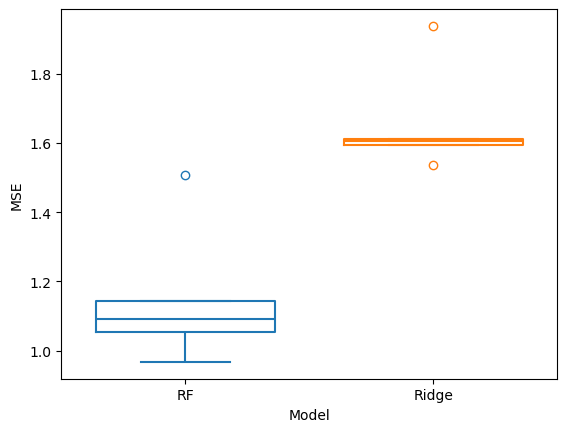

In [76]:
sns.boxplot({"RF": rf_mse_cv, "Ridge": ridge_mse_cv}, fill=False, gap=0.1)
plt.xlabel("Model")
plt.ylabel("MSE")
plt.show()

### Hyperparameter tuning unsing grid search
So far, we have relied on default model parameters. However, these hyperparameters — for example, the number of estimators in a Random Forest — can be adjusted to *better* fit the structure of the given data. Finding the best combination of hyperparameters can be quite challenging, especially in terms of runtime. When the search space is relatively small, a **grid search** (i.e., an exhaustive search over all possible parameter combinations) is a suitable option. To select the best model from this search, one typically uses k-fold cross-validation, provided that runtime requirements allow it.

Here, we will perform a grid search on a **very** small paramter space:

In [85]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [30, 50]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,  # NOTE: this will perform the grid search on all available processors in parallel
)

# we use the train/test split from section 2
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print(f"Best CV MSE: {-grid_search.best_score_:.3f}")

Best parameters: {'max_depth': 50, 'n_estimators': 300}
Best CV MSE: 1.151


In the steps above, we selected and tuned the best model based on the validation scores from cross-validation. However, this still means that the same data was used for both model selection and performance estimation. To obtain an unbiased estimate of the true performance, we need an entirely separate test dataset that was not involved in the training or model selection process.
For this purpose, we provide an additional EGFR activity dataset of *secret* molecules in TODO.

In [ ]:
egfr_activities_secret_df = pd.read_csv(
    "https://github.com/volkamerlab/cic_summerschool_2025/raw/refs/heads/main/data/EGFR-activities-secret.csv",
    index_col=0
)

egfr_activities_secret_df['morgan_fp'] = egfr_activities_secret_df['canonical_smiles'].apply(
    lambda smiles: fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles))
)

X_secret, y_secret = np.stack(egfr_activities_secret_df['canonical_smiles'].apply(
    lambda smiles: fpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles))
)), np.array(egfr_activities_secret_df['pIC50'])

best_model = grid_search.best_estimator_
y_pred_secret = best_model.predict(X_secret)

mse_secret = mean_squared_error(y_secret, y_pred_secret)
r2_secret = r2_score(y_secret, y_pred_secret)

print(f"Secret test set MSE: {mse_secret:.3f}")
print(f"Secret test set R^2: {r2_secret:.3f}")

## Excercises

## TODO scaffold split 

## Classification (?)

### Excerise 3 (Classification)

In [ ]:
# generate labels from pIC50, if > x => active (1), else inactive (0)
# TODO

In [ ]:
# train a RF, use f1_score as metric

In [ ]:
# in lecture learned SVM, train a SVM. Is it's performance superior to RF?

## Cluster-based Split (?) -> maybe as exercise 

### Play around with different models to beat RF